# Topic Modeling: OCD

### The first step is importing the packages that we will be using for identifying topic models.

In [1]:
# Import required packages

# DATA PREPROCESSING
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from gensim.models import Phrases

# MODELING
import sklearn
import re
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel
from gensim.corpora.dictionary import Dictionary
from numpy import array

# VISUALIZATION
import matplotlib.pyplot as plt
import seaborn as sns
import pyLDAvis
import pyLDAvis.gensim
import pickle 

# OTHER
import numpy as np
import pandas as pd
import logging
import json
import warnings
import random

warnings.filterwarnings('ignore')  

### In the second step, we read the dataset, and take a glance at what it looks like.

In [2]:
data = pd.read_csv('ocd.csv')

In [3]:
data.head()

,user_ID,followers_count,user_location,user_description,date,text,hashtags
0,8.293180e+17,294,Eora Nation,PhD candidate in gender and cultural studies @...,10/27/2021 11:59,New research out finds that #acupuncture reduc...,NaN
1,4.150866e+08,432,London,Children’s Book Illustrator 🎨 & former @pathwa...,10/27/2021 11:51,New research out finds that #acupuncture reduc...,['ocd']
2,1.311980e+18,17,NaN,One of the greatest regrets in life is being w...,10/27/2021 11:26,New research out finds that #acupuncture reduc...,['oknottobeok']
3,8.996297e+07,29198,"Boulder CO, USA",Peter Strong - Psychotherapist specializing in...,10/27/2021 11:25,New research out finds that #acupuncture reduc...,['OCD']
4,8.853120e+17,981,Hell,A free thinker and freelance writer\r\r\n\r\r\...,10/27/2021 11:06,New research out finds that #acupuncture reduc...,NaN


### Then, we extract our column of interest, which is the tweet.

In [4]:
tweets = data['text']

### Once we have the tweets, we pre-process the data to make it ready for analysis.

Initially, we convert everything to lowercase, and then we remove users, links, punctuation, double spaces, numbers, short words, emojis and stopwords.

Then, we tokenize each word, splitting the sentences in separate words.

Lasly, we convert each word into their lemmas (the form of a word under which it is registered in a dictionary).

In [5]:
# list of commonly repeated words that do not add meanings
my_stopwords = nltk.corpus.stopwords.words('english')
repeated_words = ['ever', 'start', 'pre', '&amp', 
                  'amp', 'may', 'and', 'when',
                  'what','who', 'why','how', 
                  'this', 'your', 'mine', 'their',
                  'her', 'his', 'that', 'mental']

for i in repeated_words:
    my_stopwords.append(i)
    
tweets = tweets.apply(lambda x: ' '.join([word for word in x.split() if word not in (my_stopwords)]))
tweets = array(tweets)
    
# list of common punctuation    
my_punctuation = '!"$%&\'()*+,-./:;<=>?[\\]^_`’{|}~•@'

# list of the majority of emojis
emoj = re.compile("["  
    u"\U0001F600-\U0001F64F" 
    u"\U0001F300-\U0001F5FF" 
    u"\U0001F680-\U0001F6FF"  
    u"\U0001F1E0-\U0001F1FF"  
    u"\U00002500-\U00002BEF"  
    u"\U00002702-\U000027B0"
    u"\U00002702-\U000027B0"
    u"\U000024C2-\U0001F251"
    u"\U0001f926-\U0001f937"
    u"\U00010000-\U0010ffff"
    u"\u2640-\u2642" 
    u"\u2600-\u2B55"
    u"\u200d"
    u"\u23cf"
    u"\u23e9"
    u"\u231a"
    u"\ufe0f"  
    u"\u3030"
                  "]+", re.UNICODE) 

In [6]:
def preprocessor(tweets):
    """
    Removes unnecessary information from tweets,
    and lemmatizes the tweets.

    Input(s):
    ------------------------------
    tweets(array): all original tweets
    
    Output(s):
    ------------------------------
    tweets(array): cleaned up and lemmatized tweets
    """
    tokenizer = RegexpTokenizer(r'\w+')
    for idx in range(len(tweets)):       
        tweets[idx] = re.sub(r'http\S+', '', tweets[idx]) # http links
        tweets[idx] = re.sub(r'bit.ly/\S+', '', tweets[idx]) # bitly links
        tweets[idx] = tweets[idx].strip('[link]') # other links(i.e. gifs)
        tweets[idx] = tweets[idx].lower()  # turn to lowercase
        tweets[idx] = re.sub('(RT\s@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweets[idx]) # retweets
        tweets[idx] = re.sub('(@[A-Za-z]+[A-Za-z0-9-_]+)', '', tweets[idx]) # tweeted at
        tweets[idx] = re.sub ('#', '', tweets[idx]) # hashtags
        tweets[idx] = re.sub(emoj, '', tweets[idx]) # emojis
        tweets[idx] = re.sub('['+my_punctuation + ']+', ' ', tweets[idx]) # remove punctuation
        tweets[idx] = re.sub('\s+', ' ', tweets[idx]) # remove double spacing
        tweets[idx] = tokenizer.tokenize(tweets[idx])   # split into words


    # numbers (but not words with number)
    tweets = [[token for token in tweet if not token.isdigit()] for tweet in tweets]
    
    # words that are only one character
    tweets = [[token for token in tweet if len(token) > 3] for tweet in tweets]
    
    tweets = [[token for token in tweet if len(token) > 3] for tweet in tweets]
    
    # lemmatize all words in documents
    lemmatizer = WordNetLemmatizer()
    tweets = [[lemmatizer.lemmatize(token) for token in tweet] for tweet in tweets]
 
    return tweets

In [7]:
tweets = preprocessor(tweets)

### We also create bi- and trigrams, and remove words that appear rarely. This is words that occurr frequently together, for example "more_than, less_than".

In [8]:
# add bigrams and trigrams to docs

# only add bi/trigrams that appear > 10 times
bigram = Phrases(tweets, min_count=10)
trigram = Phrases(bigram[tweets])

for idx in range(len(tweets)):
    for token in bigram[tweets[idx]]:
        if '_' in token:
            tweets[idx].append(token)
    for token in trigram[tweets[idx]]:
        if '_' in token:
            tweets[idx].append(token)

dictionary = Dictionary(tweets)
dictionary.filter_extremes(no_below=10, no_above=0.2)

corpus = [dictionary.doc2bow(t) for t in tweets]

### After being ready for analysis, we analyze this data with Latent Dirichlet Allocation model by assigning a random number of topics.

In [9]:
num_topics = 5 # number of topics

temp = dictionary[0] 
id2word = dictionary.id2token

lda_model = LdaModel(corpus=corpus, id2word=id2word, chunksize=(len(data)/5), \
                       alpha='auto', eta='auto', \
                       iterations=20, num_topics=num_topics, \
                       passes=20, eval_every=1)

# show keywords
print(lda_model.print_topics())

[(0, '0.033*"help_mentalhealth" + 0.031*"online_counseling" + 0.027*"online" + 0.023*"depression" + 0.021*"research_find" + 0.021*"acupuncture" + 0.021*"evidence_back" + 0.021*"ssri_performance" + 0.021*"always_known" + 0.019*"online_psychotherapy"'), (1, '0.029*"mentalhealth" + 0.028*"mentalhealth_bipolar" + 0.017*"obsessive_compulsive" + 0.014*"bipolar" + 0.013*"disorder" + 0.012*"like" + 0.010*"thought" + 0.009*"thing" + 0.009*"time" + 0.008*"depression"'), (2, '0.083*"hive" + 0.056*"hiveblogshare" + 0.043*"life" + 0.041*"proofofbrain" + 0.040*"community" + 0.039*"brain" + 0.039*"clean" + 0.038*"your" + 0.037*"organized" + 0.037*"house"'), (3, '0.038*"online" + 0.036*"mindfulness_therapy" + 0.029*"mindfulness" + 0.025*"online_therapist" + 0.024*"therapy" + 0.023*"ocdrecovery_ocdawareness" + 0.020*"ocdrecovery" + 0.016*"skype" + 0.015*"mindfulness_depressio" + 0.015*"want_make"'), (4, '0.043*"health" + 0.036*"ocdrecovery" + 0.036*"condition" + 0.036*"ocdawareness" + 0.036*"know" + 0.

### We check the accuracy of our model with coherence scores (through CV, and UMass)

High values of c_v and low values of UMass indicate higher accuracy.

In [10]:
# coherence score (c_v)
coherence_model_cv = CoherenceModel(model=lda_model, texts=tweets, dictionary=dictionary, coherence='c_v')
coherence_score = coherence_model_cv.get_coherence()
print('\nCoherence Score: ', coherence_score)


Coherence Score:  0.30024866765007296


In [11]:
coherence_model_cv = CoherenceModel(model=lda_model, texts=tweets, dictionary=dictionary, coherence='u_mass')
coherence_score = coherence_model_cv.get_coherence()
print('\nCoherence Score: ', coherence_score)


Coherence Score:  -11.681981643672533


### To determine the ideal number of topics, we run a simulation with different number of topics and keep track of the coherence scores.

In [12]:
def simulate_coherence_values(dictionary, corpus, texts, limit=11):
    """
    Simulate c_v for multiple LDA models with different number of topics.

    Input:
    ----------
    dictionary (dict) : gensim dictionary
    corpus (list): gensim corpus
    texts (list): list of input texts
    limit (int): maximum number of topics

    Output:
    -------
     coherence_scores : coherence scores corresponding to the LDA model with respective number of topics
    """
    coherence_scores = []
    models = []
    for num_topics in range(2,limit):
        model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_scores.append(coherencemodel.get_coherence())
        models.append(model)

    return coherence_scores, models

In [13]:
coherence_values, models = simulate_coherence_values(dictionary=dictionary, corpus=corpus, texts=tweets)

In [14]:
coherence_values

[0.5932978365030674,
 0.462720141825056,
 0.40102525778156284,
 0.6054316825347248,
 0.6337215146425216,
 0.5171591634198498,
 0.47408856685530615,
 0.4939858116155507,
 0.4744586160906441]

In [15]:
# pick the best model, with the highest coherence score
best_model = models[(coherence_values.index(max(coherence_values)))]

### We plot the results of the simulation and find out that the ideal number of topics is 5.

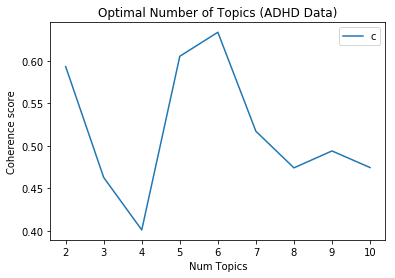

In [16]:
limit=11; start=2; 
x = range(start, limit)
plt.plot(x, coherence_values)
plt.title('Optimal Number of Topics (ADHD Data)')
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

### Once we have the weights and frequency of topic words, we are able to visualize the topics.

In [17]:
# visualize the topics
pyLDAvis.enable_notebook()
LDAvis_viz = pyLDAvis.gensim.prepare(best_model, corpus, dictionary)
LDAvis_viz

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.105886 -0.202247       1        1  22.953692
1     -0.057336  0.202148       2        1  21.593784
2      0.071004  0.037749       3        1  17.410312
4     -0.306617 -0.066570       4        1  13.429956
0      0.135125  0.101116       5        1  13.373064
5      0.051938 -0.072196       6        1  11.239192, topic_info=                                            Term        Freq       Total  \
term                                                                       
241                               tough_fabulous  280.000000  280.000000   
340                         mentalhealth_bipolar  517.000000  517.000000   
19                             help_mentalhealth  264.000000  264.000000   
238                                 stephen_gold  187.000000  187.000000   
224                               best_fictional  187.000000  187.000000   
49                                        online  690.000000  690.000000   
33                                          hive  445.000000  445.000000   
0                                    acupuncture  178.000000  178.000000   
4                                   always_known  177.000000  177.000000   
14                                 evidence_back  176.000000  176.000000   
29                              ssri_performance  176.000000  176.000000   
26                                 research_find  175.000000  175.000000   
213                             online_therapist  340.000000  340.000000   
76                           mindfulness_therapy  588.000000  588.000000   
39                                          posh  292.000000  292.000000   
81                          obsessive_compulsive  374.000000  374.000000   
132                     ocdrecovery_ocdawareness  315.000000  315.000000   
380                           hive_hiveblogshare  285.000000  285.000000   
3                                         always  157.000000  157.000000   
50                             online_counseling  205.000000  205.000000   
104                                      bipolar  335.000000  335.000000   
229                                     fabulous   97.000000   97.000000   
245                                         when  120.000000  120.000000   
240                                        tough   97.000000   97.000000   
231                                         gold   96.000000   96.000000   
236                                         pray   97.000000   97.000000   
230                                    fictional   97.000000   97.000000   
244              tuesdaybookblog_pray_when_dying   94.000000   94.000000   
225                                    depiction   94.000000   94.000000   
239                  stephen_gold_best_fictional   94.000000   94.000000   
...                                          ...         ...         ...   
160                                 odesa_travel   25.937882   30.505370   
156                                   must_place   25.776831   30.564014   
516   online_psychotherapist_obsessive_intrusive   18.123243   21.245090   
149                                 architecture   17.804169   20.867365   
33                                          hive  222.116497  445.814256   
39                                          posh  143.869339  292.429718   
57                                   photography   64.479792  107.467169   
471                       online_psychotherapist   76.354578  145.673116   
366                                   leofinance   23.866314   30.627041   
56                     hiveblogshare_photography   21.525388   26.897562   
135                                       autism   50.185796   99.920234   
35                                 hiveblogshare   76.540637  193.746750   
472                              psychotherapist   37.762348   65.081667   
271                        mi

### We interpret the topics based on the keywords

In [68]:
print('1: Comorbidity/Impact')
print('2: (Online) Therapy')
print('3: Experience/Symptoms')
print('4: Irrelevant')
print('5: Treatment/Tips')
print('6: Irrelevant')

1: Comorbidity/Impact
2: (Online) Therapy
3: Experience/Symptoms
4: Irrelevant
5: Treatment/Tips
6: Irrelevant


### Finally, we label the data and save it.

In [69]:
cat_name = ['Comorbidity/Impact', '(Online) Therapy', 'Experience/Symptoms', 'Irrelevant','Treatment/Tips', 'Irrelevant']

In [70]:
def add_labels(model=best_model, corpus=corpus, data=data):
    # get main topic in each document
    topics = []
    categories = []
    for i, row in enumerate(model[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # dominant topic
                wp = model.show_topic(topic_num)
                topics.append(topic_num+1)
                categories.append(cat_name[topic_num])
            else:
                break
    data['category'] = categories
    data['class'] = topics
    return data.reset_index()

In [71]:
len(cat_name)

6

In [72]:
data_labelled = add_labels(model=best_model, corpus=corpus, data=data)

In [73]:
data_labelled.category.describe()

count           2863
unique             5
top       Irrelevant
freq            1033
Name: category, dtype: object

In [74]:
data_labelled['class'].unique()

array([1, 6, 5, 4, 2, 3], dtype=int64)

In [75]:
data.head()

,user_ID,followers_count,user_location,user_description,date,text,hashtags,category,class
0,8.293180e+17,294,Eora Nation,PhD candidate in gender and cultural studies @...,10/27/2021 11:59,New research out finds that #acupuncture reduc...,NaN,Comorbidity/Impact,1
1,4.150866e+08,432,London,Children’s Book Illustrator 🎨 & former @pathwa...,10/27/2021 11:51,New research out finds that #acupuncture reduc...,['ocd'],Comorbidity/Impact,1
2,1.311980e+18,17,NaN,One of the greatest regrets in life is being w...,10/27/2021 11:26,New research out finds that #acupuncture reduc...,['oknottobeok'],Comorbidity/Impact,1
3,8.996297e+07,29198,"Boulder CO, USA",Peter Strong - Psychotherapist specializing in...,10/27/2021 11:25,New research out finds that #acupuncture reduc...,['OCD'],Comorbidity/Impact,1
4,8.853120e+17,981,Hell,A free thinker and freelance writer\r\r\n\r\r\...,10/27/2021 11:06,New research out finds that #acupuncture reduc...,NaN,Comorbidity/Impact,1


In [77]:
for i in range(3):
    random_tweet = random.randint(1,len(data))
    print('Tweet:', data.text[random_tweet])
    print('************************************************************')
    print('Category:', data.category[random_tweet])
    print('--------------------------------------------------------------------------------------------------------------------------------')

Tweet: I think her sign turned out beautiful, letting people know #OCD is not some personality trait to be made light of. https://t.co/ZDMese8GL5
************************************************************
Category: Experience/Symptoms
--------------------------------------------------------------------------------------------------------------------------------


 #Unbelievable #OCD #Mentalhealth #shortstory
************************************************************
Category: Experience/Symptoms
--------------------------------------------------------------------------------------------------------------------------------


#hive #naturalmedicine #garden #nature #posh #ocd
************************************************************
Category: Irrelevant
--------------------------------------------------------------------------------------------------------------------------------


In [78]:
data.to_csv('OCD with TM labels.csv')